### Import required libraies

In [6]:
import os, json
from tqdm import tqdm
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

import lightgbm as lgb
from xgboost import XGBClassifier
import xgboost as xgb_module

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers

### Config

In [7]:
CSV_PATH = "mitbih_final_complete_features.csv"
MODEL_DIR = "saved_models"
os.makedirs(MODEL_DIR, exist_ok=True)

RAW_SIGNAL_LEN = 200   # expected columns '0'..'199'
RANDOM_STATE = 42
TEST_SIZE = 0.15
SKFOLD = 5
BATCH_SIZE = 128
EPOCHS = 40

# Ensemble weights (final prob = w_meta*meta_prob + w_hybrid*hybrid_prob)
W_META = 0.5
W_HYBRID = 0.5

# Label mapping
NORMAL_SYMBOLS = set(['N','L','R','e','j'])  # mapping these to Normal=0; everything else -> Abnormal=1

### Load data

In [8]:
print("Loading CSV:", CSV_PATH)
df = pd.read_csv(CSV_PATH)
print("Rows:", len(df), "Columns:", len(df.columns))

# check signal columns
signal_cols = [str(i) for i in range(RAW_SIGNAL_LEN)]
for c in signal_cols:
    if c not in df.columns:
        raise RuntimeError(f"Signal column '{c}' missing. Check RAW_SIGNAL_LEN / CSV content.")

# select tabular features (auto-detect)
tabular_candidates = ['mean','std','min','max','energy','skewness','kurtosis', 'r_peak_amplitude','rr_interval_sec','spectral_energy']
tabular_cols = [c for c in tabular_candidates if c in df.columns]
if len(tabular_cols) == 0:
    raise RuntimeError("No tabular feature columns found. Adjust `tabular_candidates`.")
print("Using tabular features:", tabular_cols)

# build X and y
X_signal = df[signal_cols].astype(np.float32).values
X_tabular = df[tabular_cols].fillna(0).astype(np.float32).values
y_symbols = df['label'].astype(str).values

# map to binary: 0 normal, 1 abnormal
y_binary = np.array([0 if s in NORMAL_SYMBOLS else 1 for s in y_symbols], dtype=np.int32)
print("Binary label distribution (0=Normal, 1=Abnormal):", np.bincount(y_binary))

# Save mapping for future
mapping_info = {"normal_symbols": list(NORMAL_SYMBOLS)}
with open(os.path.join(MODEL_DIR, "label_mapping.json"), "w") as f:
    json.dump(mapping_info, f, indent=2)

Loading CSV: mitbih_final_complete_features.csv
Rows: 112551 Columns: 211
Using tabular features: ['mean', 'std', 'min', 'max', 'energy', 'skewness', 'kurtosis', 'r_peak_amplitude', 'rr_interval_sec', 'spectral_energy']
Binary label distribution (0=Normal, 1=Abnormal): [90589 21962]


### Train test split

In [9]:
Xsig_train, Xsig_test, Xtab_train, Xtab_test, y_train, y_test = train_test_split(
    X_signal, X_tabular, y_binary, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y_binary
)
print("Train/Test shapes:", Xsig_train.shape, Xsig_test.shape)

# scale tabular features
scaler = StandardScaler()
Xtab_train_scaled = scaler.fit_transform(Xtab_train)
Xtab_test_scaled = scaler.transform(Xtab_test)
joblib.dump(scaler, os.path.join(MODEL_DIR, "scaler_tab.pkl"))
print("Saved tabular scaler.")

Train/Test shapes: (95668, 200) (16883, 200)
Saved tabular scaler.


### Stacking (binary) using StratifiedKFold

In [10]:
skf = StratifiedKFold(n_splits=SKFOLD, shuffle=True, random_state=RANDOM_STATE)

# Base learner params
rf_params = {'n_estimators': 300, 'max_depth': 15, 'random_state': RANDOM_STATE, 'n_jobs': -1}

# XGBoost params
xgb_params = {
    'n_estimators': 400,
    'learning_rate': 0.05,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'binary:logistic',
    'random_state': RANDOM_STATE,
}

lgb_params = {'objective': 'binary', 'metric': 'binary_logloss',
              'learning_rate': 0.05, 'num_leaves': 31, 'feature_fraction': 0.8,
              'bagging_fraction': 0.8, 'bagging_freq': 5, 'seed': RANDOM_STATE}

n_train = Xtab_train_scaled.shape[0]
n_test = Xtab_test_scaled.shape[0]

oof_train = np.zeros((n_train, 3))
oof_test = np.zeros((n_test, 3))

print("\nStarting stacking OOF generation...")
for fold, (tr_idx, val_idx) in enumerate(skf.split(Xtab_train_scaled, y_train)):
    print(f"\n--- Fold {fold+1}/{SKFOLD} ---")
    X_tr, X_val = Xtab_train_scaled[tr_idx], Xtab_train_scaled[val_idx]
    y_tr, y_val = y_train[tr_idx], y_train[val_idx]

    # Random Forest
    rf = RandomForestClassifier(**rf_params)
    rf.fit(X_tr, y_tr)
    oof_train[val_idx, 0] = rf.predict_proba(X_val)[:,1]
    oof_test[:, 0] += rf.predict_proba(Xtab_test_scaled)[:,1] / SKFOLD

    # XGBoost
    xgb_clf = XGBClassifier(**xgb_params)
    try:
        xgb_clf.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], early_stopping_rounds=50, verbose=False)
    except TypeError:
        try:
            xgb_clf.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], callbacks=[xgb_module.callback.EarlyStopping(rounds=50)], verbose=False)
        except Exception:
            xgb_clf.fit(X_tr, y_tr, verbose=False)
    oof_train[val_idx, 1] = xgb_clf.predict_proba(X_val)[:,1]
    oof_test[:, 1] += xgb_clf.predict_proba(Xtab_test_scaled)[:,1] / SKFOLD

    # LightGBM
    lgb_tr = lgb.Dataset(X_tr, label=y_tr)
    lgb_val = lgb.Dataset(X_val, label=y_val, reference=lgb_tr)
    lgb_model = lgb.train(params=lgb_params, train_set=lgb_tr, valid_sets=[lgb_val],
                          num_boost_round=1000,
                          callbacks=[lgb.early_stopping(stopping_rounds=50),
                                     lgb.log_evaluation(period=100)])
    oof_train[val_idx, 2] = lgb_model.predict(X_val)
    oof_test[:, 2] += lgb_model.predict(Xtab_test_scaled) / SKFOLD

    del rf, xgb_clf, lgb_model

print("\nOut Of Fold prediction generation complete. Training meta-learner (Logistic Regression)...")
meta_lr = LogisticRegression(max_iter=2000)
meta_lr.fit(oof_train, y_train)

meta_test_feats = np.zeros((n_test, 3))
meta_test_feats[:,0] = oof_test[:,0]
meta_test_feats[:,1] = oof_test[:,1]
meta_test_feats[:,2] = oof_test[:,2]

meta_test_probs = meta_lr.predict_proba(meta_test_feats)[:,1]
meta_test_preds = (meta_test_probs >= 0.5).astype(int)
print("\nMeta (stacked) Test Metrics:")
print(classification_report(y_test, meta_test_preds, target_names=['Normal','Abnormal']))
print("Meta Accuracy:", accuracy_score(y_test, meta_test_preds))


Starting stacking OOF generation...

--- Fold 1/5 ---
[LightGBM] [Info] Number of positive: 14934, number of negative: 61600
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006586 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 76534, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195129 -> initscore=-1.417021
[LightGBM] [Info] Start training from score -1.417021
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.130629
[200]	valid_0's binary_logloss: 0.109143
[300]	valid_0's binary_logloss: 0.0995814
[400]	valid_0's binary_logloss: 0.0934535
[500]	valid_0's binary_logloss: 0.0892417
[600]	valid_0's binary_logloss: 0.0865338
[700]	valid_0's binary_logloss: 0.0838198
[800]	valid_0's binary_logloss: 0.0823523
[900]	valid_0's binary_logloss: 0.0813086
[1000]	valid_0

### Train full base models for saving

In [11]:
rf_full = RandomForestClassifier(**rf_params)
rf_full.fit(Xtab_train_scaled, y_train)
joblib.dump(rf_full, os.path.join(MODEL_DIR, "rf_full.pkl"))

xgb_full = XGBClassifier(**xgb_params)
try:
    xgb_full.fit(Xtab_train_scaled, y_train, eval_set=[(Xtab_test_scaled, y_test)], early_stopping_rounds=50, verbose=False)
except TypeError:
    try:
        xgb_full.fit(Xtab_train_scaled, y_train, eval_set=[(Xtab_test_scaled, y_test)], callbacks=[xgb_module.callback.EarlyStopping(rounds=50)], verbose=False)
    except Exception:
        xgb_full.fit(Xtab_train_scaled, y_train, verbose=False)
joblib.dump(xgb_full, os.path.join(MODEL_DIR, "xgb_full.pkl"))

lgb_full = lgb.train(params=lgb_params, train_set=lgb.Dataset(Xtab_train_scaled, label=y_train),
                     valid_sets=[lgb.Dataset(Xtab_test_scaled, label=y_test)],
                     num_boost_round=1000,
                     callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(period=100)])
lgb_full.save_model(os.path.join(MODEL_DIR, "lgb_full.txt"))

joblib.dump(meta_lr, os.path.join(MODEL_DIR, "meta_lr.pkl"))

[LightGBM] [Info] Number of positive: 18668, number of negative: 77000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008295 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 95668, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195133 -> initscore=-1.416995
[LightGBM] [Info] Start training from score -1.416995
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.135779
[200]	valid_0's binary_logloss: 0.114923
[300]	valid_0's binary_logloss: 0.10616
[400]	valid_0's binary_logloss: 0.0997265
[500]	valid_0's binary_logloss: 0.095816
[600]	valid_0's binary_logloss: 0.0931384
[700]	valid_0's binary_logloss: 0.0910749
[800]	valid_0's binary_logloss: 0.0889958
[900]	valid_0's binary_logloss: 0.0878413
[1000]	valid_0's binary_logloss: 0.0867422
Did not meet early stopping. 

['saved_models/meta_lr.pkl']

### Hybrid CNN+biLSTM model

In [12]:
def build_hybrid_model(signal_len=RAW_SIGNAL_LEN, tab_dim=Xtab_train_scaled.shape[1]):
    inp_signal = layers.Input(shape=(signal_len,1), name="signal_input")
    x = layers.Conv1D(32, kernel_size=7, padding='same', activation='relu')(inp_signal)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool1D(2)(x)
    x = layers.Conv1D(64, kernel_size=5, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool1D(2)(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=False))(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)

    inp_tab = layers.Input(shape=(tab_dim,), name="tab_input")
    t = layers.Dense(64, activation='relu')(inp_tab)
    t = layers.BatchNormalization()(t)
    t = layers.Dropout(0.2)(t)
    t = layers.Dense(32, activation='relu')(t)

    m = layers.Concatenate()([x, t])
    m = layers.Dense(128, activation='relu')(m)
    m = layers.Dropout(0.3)(m)
    out = layers.Dense(1, activation='sigmoid')(m)

    return models.Model(inputs=[inp_signal, inp_tab], outputs=out)

hybrid = build_hybrid_model()
hybrid.compile(optimizer=optimizers.Adam(learning_rate=1e-3),
               loss='binary_crossentropy', metrics=['accuracy'])

Xsig_train_cnn = Xsig_train.reshape((-1, RAW_SIGNAL_LEN, 1))
Xsig_test_cnn = Xsig_test.reshape((-1, RAW_SIGNAL_LEN, 1))

cw_vals = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i: cw_vals[i] for i in range(len(cw_vals))}

hybrid_ckpt = os.path.join(MODEL_DIR, "hybrid_best_binary.h5")
cb_list = [
    callbacks.ModelCheckpoint(hybrid_ckpt, monitor='val_loss', save_best_only=True),
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=6, verbose=1),
    callbacks.EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True, verbose=1)
]

Xsig_tr_fit, Xsig_val_fit, Xtab_tr_fit, Xtab_val_fit, y_tr_fit, y_val_fit = train_test_split(
    Xsig_train_cnn, Xtab_train_scaled, y_train, test_size=0.12, random_state=RANDOM_STATE, stratify=y_train
)

history = hybrid.fit(
    {"signal_input": Xsig_tr_fit, "tab_input": Xtab_tr_fit},
    y_tr_fit,
    validation_data=({"signal_input": Xsig_val_fit, "tab_input": Xtab_val_fit}, y_val_fit),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    class_weight=class_weights,
    callbacks=cb_list,
    verbose=2
)

hybrid.save(os.path.join(MODEL_DIR, "hybrid_final_binary.h5"))

hybrid_best = models.load_model(hybrid_ckpt)
hybrid_probs = hybrid_best.predict({"signal_input": Xsig_test_cnn, "tab_input": Xtab_test_scaled}, batch_size=256).ravel()
hybrid_preds = (hybrid_probs >= 0.5).astype(int)

Epoch 1/40


658/658 - 20s - 31ms/step - accuracy: 0.9296 - loss: 0.1891 - val_accuracy: 0.9586 - val_loss: 0.1090 - learning_rate: 1.0000e-03
Epoch 2/40


658/658 - 10s - 16ms/step - accuracy: 0.9614 - loss: 0.1101 - val_accuracy: 0.9684 - val_loss: 0.0798 - learning_rate: 1.0000e-03
Epoch 3/40


658/658 - 10s - 15ms/step - accuracy: 0.9683 - loss: 0.0897 - val_accuracy: 0.9748 - val_loss: 0.0726 - learning_rate: 1.0000e-03
Epoch 4/40


658/658 - 10s - 15ms/step - accuracy: 0.9734 - loss: 0.0777 - val_accuracy: 0.9781 - val_loss: 0.0622 - learning_rate: 1.0000e-03
Epoch 5/40
658/658 - 10s - 16ms/step - accuracy: 0.9754 - loss: 0.0703 - val_accuracy: 0.9792 - val_loss: 0.0645 - learning_rate: 1.0000e-03
Epoch 6/40


658/658 - 10s - 16ms/step - accuracy: 0.9786 - loss: 0.0614 - val_accuracy: 0.9835 - val_loss: 0.0517 - learning_rate: 1.0000e-03
Epoch 7/40
658/658 - 11s - 16ms/step - accuracy: 0.9799 - loss: 0.0568 - val_accuracy: 0.9733 - val_loss: 0.0712 - learning_rate: 1.0000e-03
Epoch 8/40
658/658 - 11s - 16ms/step - accuracy: 0.9816 - loss: 0.0521 - val_accuracy: 0.9786 - val_loss: 0.0595 - learning_rate: 1.0000e-03
Epoch 9/40
658/658 - 11s - 16ms/step - accuracy: 0.9823 - loss: 0.0508 - val_accuracy: 0.9737 - val_loss: 0.0717 - learning_rate: 1.0000e-03
Epoch 10/40


658/658 - 10s - 15ms/step - accuracy: 0.9826 - loss: 0.0486 - val_accuracy: 0.9827 - val_loss: 0.0510 - learning_rate: 1.0000e-03
Epoch 11/40
658/658 - 10s - 16ms/step - accuracy: 0.9849 - loss: 0.0425 - val_accuracy: 0.9814 - val_loss: 0.0574 - learning_rate: 1.0000e-03
Epoch 12/40
658/658 - 10s - 16ms/step - accuracy: 0.9847 - loss: 0.0431 - val_accuracy: 0.9791 - val_loss: 0.0550 - learning_rate: 1.0000e-03
Epoch 13/40


658/658 - 10s - 16ms/step - accuracy: 0.9851 - loss: 0.0408 - val_accuracy: 0.9848 - val_loss: 0.0469 - learning_rate: 1.0000e-03
Epoch 14/40
658/658 - 10s - 16ms/step - accuracy: 0.9863 - loss: 0.0393 - val_accuracy: 0.9825 - val_loss: 0.0555 - learning_rate: 1.0000e-03
Epoch 15/40
658/658 - 10s - 16ms/step - accuracy: 0.9868 - loss: 0.0365 - val_accuracy: 0.9835 - val_loss: 0.0539 - learning_rate: 1.0000e-03
Epoch 16/40
658/658 - 10s - 14ms/step - accuracy: 0.9876 - loss: 0.0345 - val_accuracy: 0.9824 - val_loss: 0.0565 - learning_rate: 1.0000e-03
Epoch 17/40
658/658 - 10s - 16ms/step - accuracy: 0.9887 - loss: 0.0323 - val_accuracy: 0.9822 - val_loss: 0.0570 - learning_rate: 1.0000e-03
Epoch 18/40
658/658 - 10s - 16ms/step - accuracy: 0.9885 - loss: 0.0301 - val_accuracy: 0.9834 - val_loss: 0.0586 - learning_rate: 1.0000e-03
Epoch 19/40

Epoch 19: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
658/658 - 10s - 16ms/step - accuracy: 0.9891 - loss: 0.0295 - val_accu

66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


### Final Ensemble


All done. Saved models & artifacts in: saved_models


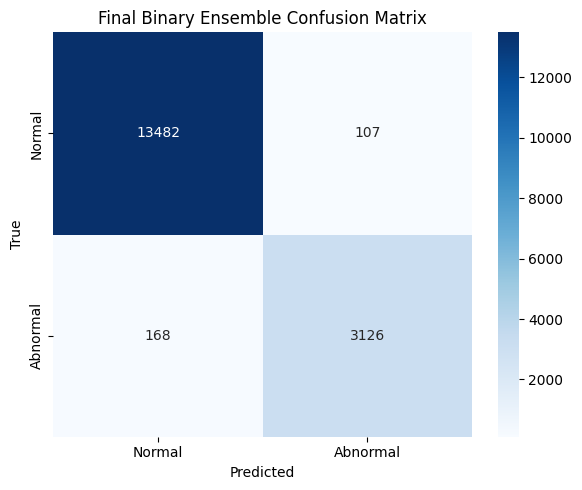

In [13]:
meta_test_feats[:,0] = rf_full.predict_proba(Xtab_test_scaled)[:,1]
meta_test_feats[:,1] = xgb_full.predict_proba(Xtab_test_scaled)[:,1]
meta_test_feats[:,2] = lgb_full.predict(Xtab_test_scaled)

meta_probs = meta_lr.predict_proba(meta_test_feats)[:,1]
final_probs = W_META * meta_probs + W_HYBRID * hybrid_probs
final_preds = (final_probs >= 0.5).astype(int)

cm = confusion_matrix(y_test, final_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal','Abnormal'], yticklabels=['Normal','Abnormal'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Final Binary Ensemble Confusion Matrix")
plt.tight_layout()
plt.savefig(os.path.join(MODEL_DIR, "final_confusion_matrix_binary.png"))

artifacts = {
    "scaler_tab": os.path.join(MODEL_DIR, "scaler_tab.pkl"),
    "rf_full": os.path.join(MODEL_DIR, "rf_full.pkl"),
    "xgb_full": os.path.join(MODEL_DIR, "xgb_full.pkl"),
    "lgb_full": os.path.join(MODEL_DIR, "lgb_full.txt"),
    "meta_lr": os.path.join(MODEL_DIR, "meta_lr.pkl"),
    "hybrid_best": hybrid_ckpt,
    "hybrid_final": os.path.join(MODEL_DIR, "hybrid_final_binary.h5"),
    "label_mapping": os.path.join(MODEL_DIR, "label_mapping.json")
}
with open(os.path.join(MODEL_DIR, "artifacts.json"), "w") as f:
    json.dump(artifacts, f, indent=2)

print("\nAll done. Saved models & artifacts in:", MODEL_DIR)